In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.mymodel import MyModel, GraphSAGEModel
from math import sqrt
import scprep

In [2]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

60

In [3]:
dataset[0].adj[0].shape

(100,)

In [4]:
t = np.arange(13)
# dataset for training
train_mask = list(t) + list(t+15) + list(t+30) + list(t+45)
# dataset for validation
val_mask = [13, 14, 28, 29, 43, 44, 58, 59]


In [5]:
def train():
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label))
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred = model(data).detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [6]:
dataset = RnaVeloDataset(root='data/')
batch_size = 1
train_mask=[0, 1]
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphSAGEModel(dataset.num_features, device).to(device)
# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(1000):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)
    # print(train_loss)

GraphSAGEModel(
  (conv1): GraphConvolutionSage (70 -> 32)
  (conv2): GraphConvolutionSage (32 -> 32)
  (lin1): Linear(in_features=32, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.4041, Train: 0.3952, Val: 0.3609
Epoch: 010, Loss: 0.1473, Train: 0.1390, Val: 0.2496
Epoch: 020, Loss: 0.0832, Train: 0.0807, Val: 0.2013
Epoch: 030, Loss: 0.0662, Train: 0.0648, Val: 0.1949
Epoch: 040, Loss: 0.0592, Train: 0.0584, Val: 0.1997
Epoch: 050, Loss: 0.0547, Train: 0.0540, Val: 0.2027
Epoch: 060, Loss: 0.0517, Train: 0.0510, Val: 0.2045
Epoch: 070, Loss: 0.0493, Train: 0.0485, Val: 0.2038
Epoch: 080, Loss: 0.0473, Train: 0.0466, Val: 0.2039
Epoch: 090, Loss: 0.0457, Train: 0.0450, Val: 0.2040
Epoch: 100, Loss: 0.0441, Train: 0.0435, Val: 0.2046
Epoch: 110, Loss: 0.0426, Train: 0.0419, Val: 0.2046
Epoch: 120, Loss: 0.0410, Train: 0.0406, Val: 0.2056
Epoch: 130, Loss: 0.0402, Train: 0.0391, Val: 0.2072
Epoch: 140, Loss: 0.0478, Train: 0.0382, Val: 0.2063
Epoch: 150, Loss: 0.0380, Train: 0.0371, 

In [7]:
def scatter(data, figsize = (15,5)):
    if isinstance(data.x, torch.Tensor):
        X_pca = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X_pca = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')

    pipeline = Pipeline([('normalize', Normalizer()), ('pca', PCA(n_components=2))])
    X_pca = pipeline.fit_transform(X_pca)

    data = data.to(device)
    pred = model(data).detach().cpu().numpy().reshape(-1)
    rmse = sqrt(mean_squared_error(y, pred))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.set_title("Prediction, RMSE="+str(rmse)[:5])
    ax2.set_title("Simulation Time")
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax2)
    plt.figure(figsize=figsize)
    plt.show()

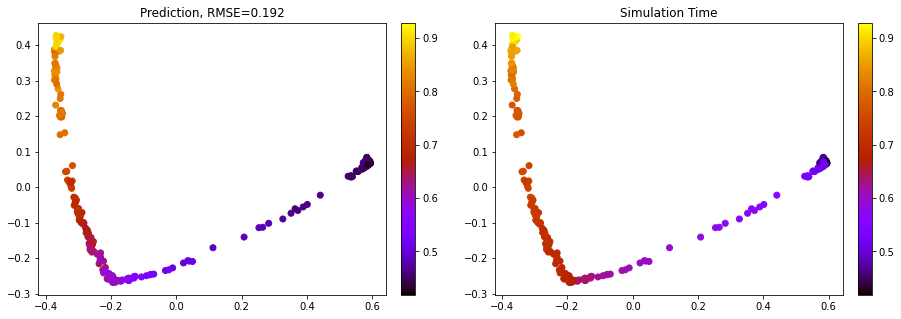

<Figure size 1080x360 with 0 Axes>

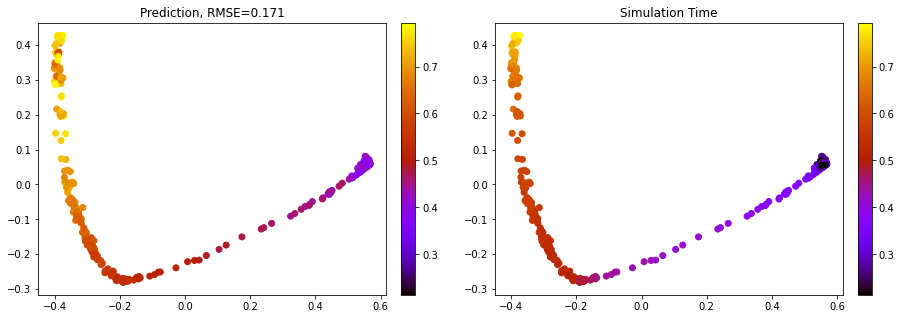

<Figure size 1080x360 with 0 Axes>

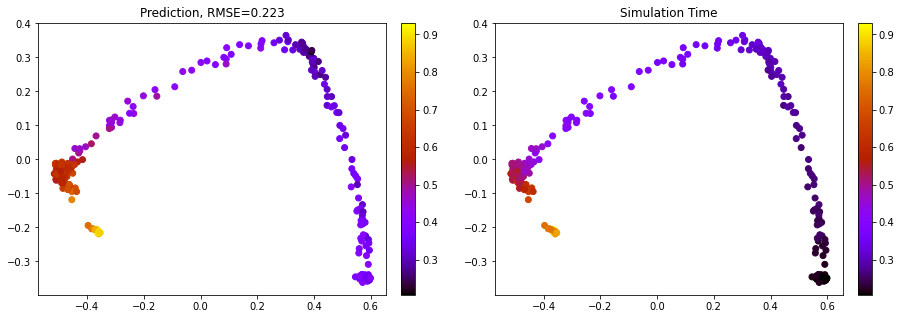

<Figure size 1080x360 with 0 Axes>

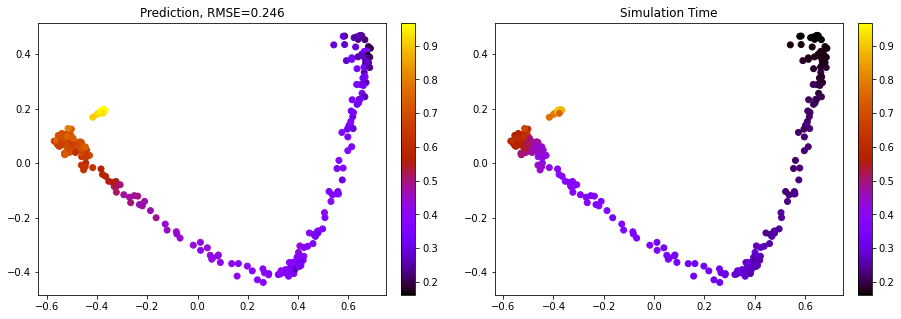

<Figure size 1080x360 with 0 Axes>

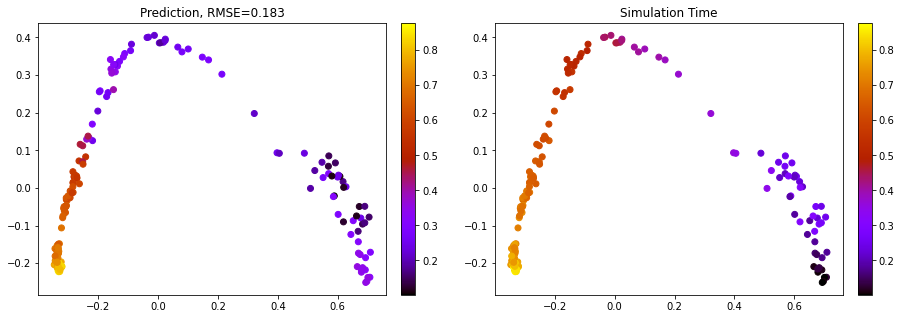

<Figure size 1080x360 with 0 Axes>

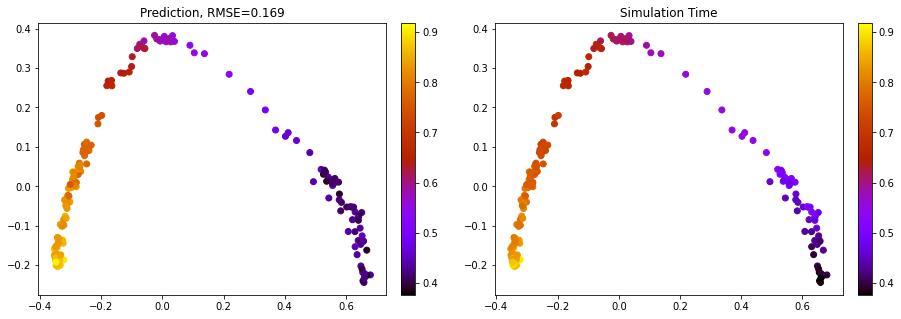

<Figure size 1080x360 with 0 Axes>

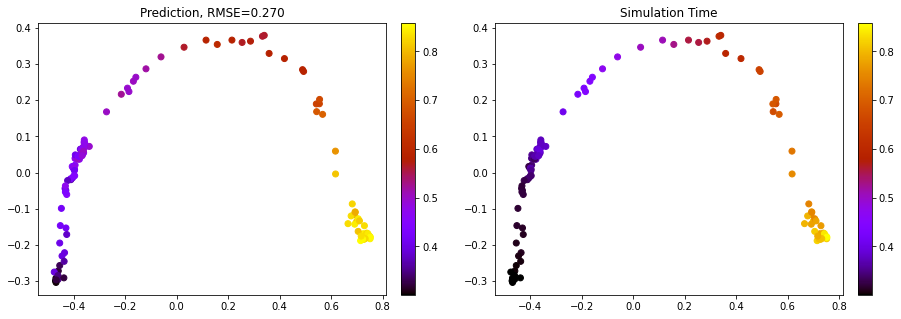

<Figure size 1080x360 with 0 Axes>

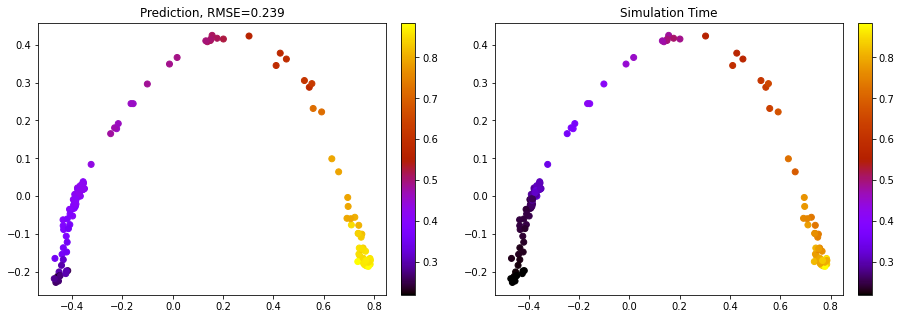

<Figure size 1080x360 with 0 Axes>

In [8]:
for data in val_loader:
    scatter(data)

## Adata List

In [9]:
backbones = ["bifurcating", "linear", "binary_tree", "trifurcating"]
seed = [1]
trans_rate = [3, 5, 10]
num_cells = [100, 150, 200, 250, 300]
root = '5_backbone/'

combined = combined = [(bb, tr, nc) for bb in backbones for tr in trans_rate for nc in num_cells]
adata_list = []

for item in combined:
    bb, tr, nc = item
    path = root + bb + "_" + str(tr) + "_1_1_" + str(nc)
    df = pd.read_csv(path + "_unspliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_unspliced = df.to_numpy()

    df = pd.read_csv(path + "_spliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_spliced = df.to_numpy()

    df = pd.read_csv(path + "_cell_info.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_obs = df

    adata = anndata.AnnData(X = csr_matrix(X_spliced),
                    obs = X_obs,
                    layers = dict(
                        unspliced = csr_matrix(X_unspliced),
                        spliced = csr_matrix(X_spliced)
                    ))
    print(X_unspliced.shape)
    adata_list.append(adata)

FileNotFoundError: [Errno 2] File 5_backbone/bifurcating_3_1_1_100_unspliced.csv does not exist: '5_backbone/bifurcating_3_1_1_100_unspliced.csv'

## Slingshot

In [13]:
from sklearn.cluster import KMeans
for i in val_mask:
    adata = adata_list[val_mask[0]]

    data = dataset[i]
    if isinstance(data.x, torch.Tensor):
        X_pca = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X_pca = data.x
    
    n_clusters = 7
    init = "k-means++"
    n_init = 10
    max_iter = 300
    tol = 0.0001
    kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
    groups = kmeans.fit_predict(X_pca)
    meta_data = adata.obs
    meta_data['groups'] = groups

    fig = plt.figure(figsize = (20,10))
    ax = fig.add_subplot()
    c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
    clusters = int(np.max(groups)+1)
    for i in range(clusters):
        sub_cells = np.where(groups == i)[0]
        progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
        
    ax.legend(['cluster '+ str(i) for i in range(clusters)])
    ax.set_title("slingshot clusters")

    X_pca_df = pd.DataFrame(index=adata.obs.cell_id, columns= np.arange(10), data = X_pca)
    # scprep.run.install_bioconductor('sli  ngshot')
    results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 6)

    break
    

OSError: cannot load library 'C:\Program Files\R\R-4.0.0\bin\x64\R.dll': error 0x7e

In [15]:
adata.obs.cell_id

0        cell1
1        cell2
2        cell3
3        cell4
4        cell5
        ...   
245    cell246
246    cell247
247    cell248
248    cell249
249    cell250
Name: cell_id, Length: 250, dtype: object

## ScVelo latent time

recovering dynamics
... 100%    finished(0:00:11)-->added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing latent time
    finished(0:00:00)-->added 
    'latent_time', shared time (adata.obs)
GNN prediction order rmse: 40.48491076932244
Scvelo latent time order rmse: 53.99025838056343


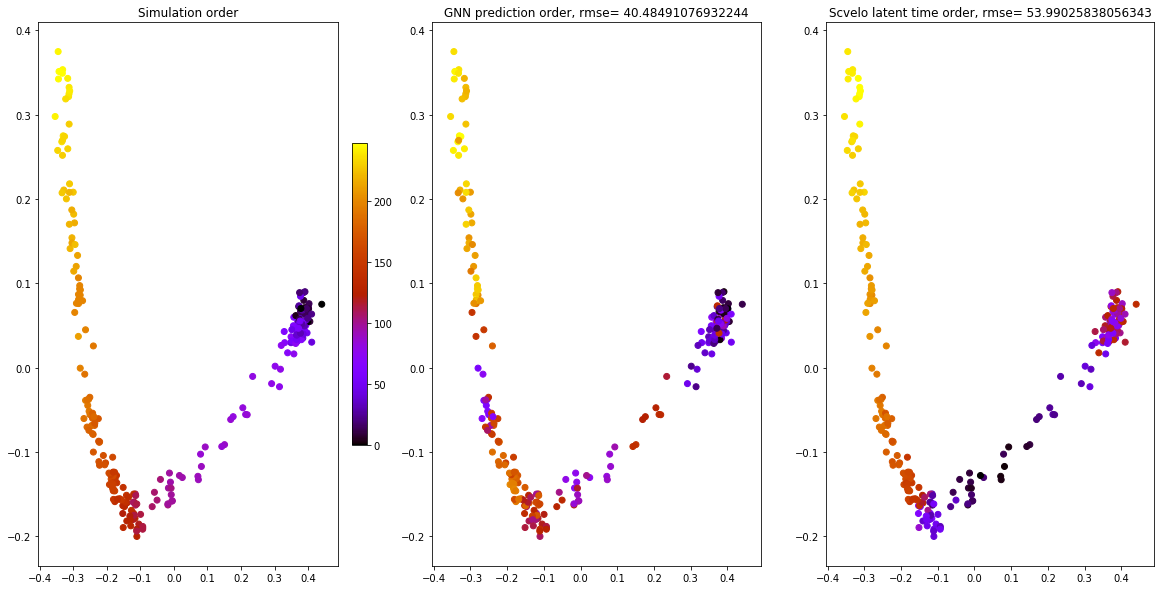

In [56]:
for i in val_mask:
    adata = adata_list[val_mask[0]]
    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.latent_time(adata)

    data = dataset[i]
    if isinstance(data.x, torch.Tensor):
        X_pca = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X_pca = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')

    data = data.to(device)
    pred = model(data).detach().cpu().numpy().reshape(-1)

    y_sorted = sorted(y)
    y_order = [y_sorted.index(i) for i in y]

    pred_sorted = sorted(pred)
    pred_order = [pred_sorted.index(i) for i in pred]
    gnn_rmse = sqrt(mean_squared_error(y_order, pred_order))
    print("GNN prediction order rmse: "+str(gnn_rmse))

    scvelo_sorted = sorted(adata.obs['latent_time'])
    scvelo_order = [scvelo_sorted.index(i) for i in adata.obs['latent_time']]
    scvelo_rmse = sqrt(mean_squared_error(y_order, scvelo_order))
    print("Scvelo latent time order rmse: " + str(scvelo_rmse))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.set_title("Simulation order")
    ax2.set_title("GNN prediction order, rmse= " + str(gnn_rmse))
    ax3.set_title("Scvelo latent time order, rmse= " + str(scvelo_rmse))
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y_order)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred_order)
    v3 = ax3.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=scvelo_order)
    
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    plt.show()
    break

In [54]:
print(adata.uns['recover_dynamics'])

{'fit_connected_states': False, 'fit_basal_transcription': None, 'use_raw': True}


## With KNN

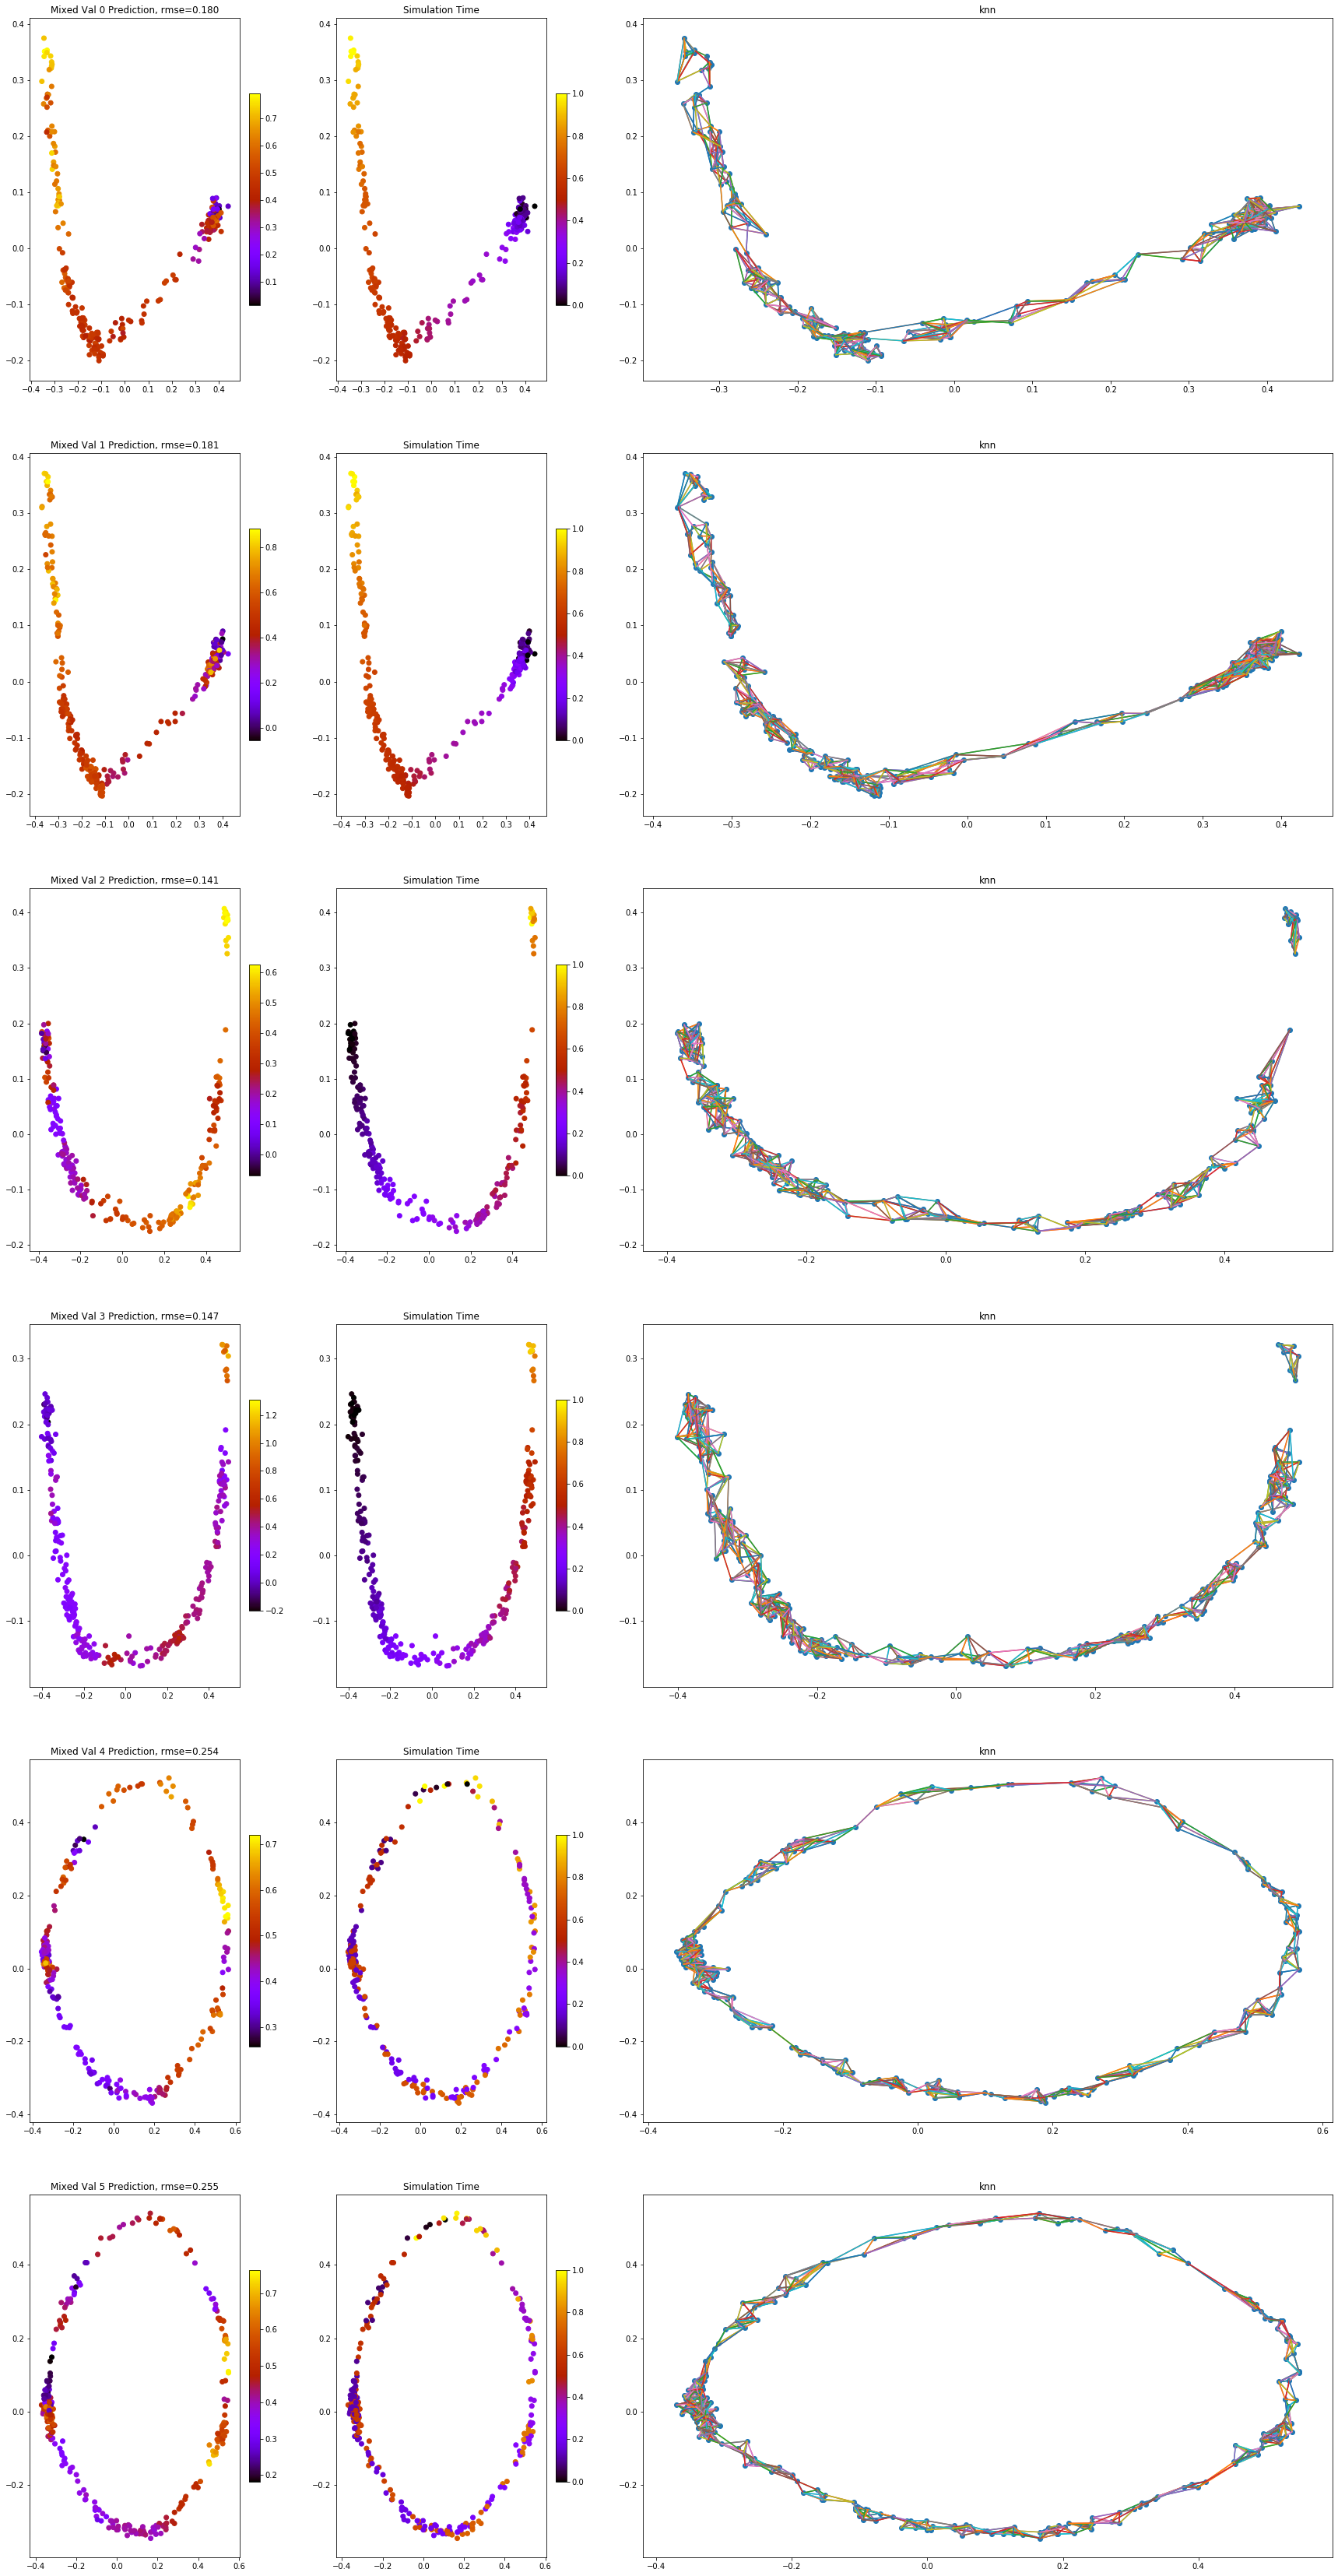

In [11]:
mask = val_mask
num_plot = len(mask)
fig, axs = plt.subplots(num_plot, 3, figsize=(30, 10*num_plot), gridspec_kw={'width_ratios': [1, 1, 3]})
for i in range(len(mask)):
    ax1, ax2, ax3 = axs[i]
    data = dataset[int(mask[i])]

    if isinstance(data.x, torch.Tensor):
        X_pca = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X_pca = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')

    edges = data.edge_index.numpy()

    pred = model(data.to(device)).detach().cpu().numpy().reshape(-1)
    rmse = sqrt(mean_squared_error(y, pred))

    prefix = "Mixed Val " + str(i)

    ax1.set_title(prefix + " Prediction, rmse=" + str(rmse)[:5])
    ax2.set_title("Simulation Time")
    ax3.set_title('knn')
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v2, fraction=0.046, pad=0.04, ax = ax2)

    ax3.scatter(X_pca[:,0], X_pca[:,1], cmap = 'gnuplot')
    for i in range(edges.shape[1]):
        ax3.plot(X_pca[edges[:,i]][:,0], X_pca[edges[:,i]][:,1])

plt.savefig("mymodel_visual/Mixed_val.png")
plt.show()

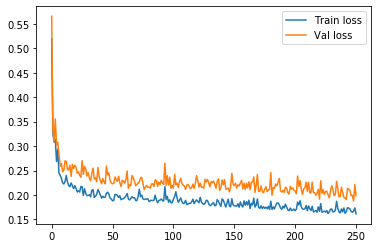

In [12]:
plt.plot(train_list)
plt.plot(val_list)
plt.legend(['Train loss', 'Val loss'])
plt.savefig('mymodel_visual/mymodel_loss.png')
plt.show()